## Business problem

Port terminals constantly strive to improve the efficiency of their operations through a careful
management of their berth facilities, machinery and personnel. 



The most important variables when planning terminal operations is knowing which vessels will arrive at the terminal and when.


MarineTraffic aims at being the best visibility providers by providing up to date vessel tracking data (using AIS), as well as additional derived information such as the estimated time of arrival (ETA) of a vessel to a port of interest.


AIS messages contain information on the port that the vessel is traveling to as well as the estimated time of arrival.

However, since ports may consist of more than one terminal, the exact terminal that the
vessel will visit is not known in advance making it difficult for MarineTraffic to assign future arrivals to terminals which, in turn, limits the ability to measure terminal congestion and calculate more accurate terminal arrival times.



A model which predicts the terminal a vessel will travel to has the potential to help all parties involved in a port call to plan their operations more effectively

# Data Description

A dataset has been extracted containing container calls at terminals that took place during the past 3
years for the Port of **Hamburg and Port of Los Angeles**. The dataset contains the following fields

A dataset has been extracted containing container calls at terminals that took place during the past 3
years for the Port of Hamburg and Port of Los Angeles. The dataset contains the following fields;


* **last_port**: Port where the *last* terminal call by vessel is recorded.



* **last_terminal**: The immediately previous *terminal* call of the vessel.


* **last_terminal_doc_timestamp**: Timestamp of previous terminal call.


* **current_port**: Port where the current terminal call by vessel is recorded.


* **current_terminal**: Current terminal call of the vessel.


* **shipname**: Name of the vessel.


* **dock_timestamp**: Timestamp of current terminal call.


* **GRT**: Vessel capacity (gross tonnage unit).


* **TEU**: Vessel capacity (twenty-foot equivalent Unit).


* **length**: Vessel length.


* **width**: Vessel width.

# Goals and Deliverable


The goal of this task is to implement & evaluate the accuracy of a solution that predicts the terminal
that a vessel will call.
**The product team claims that the history of terminals visited by a vessel in the past is a critical factor
that should be incorporated into the model**.

Some important steps that your solution would be expected to address and describe are the following:
* What features have you finally selected and engineered for your modeling approach? What led you to these choices? Why & how have you processed them?
* Which features seem to be the most important & how did you evaluate their importance?
* Do your findings agree with the product team’s insights discussed above? Before developing a ML model, how would you evaluate the importance/predictive power of one of the productidentified features as an independent variable?
* What type of prediction/training model have you chosen and why?
* How well does your predictive solution perform in terms of predicting the terminal a vessel will call?
* What different metrics/graphs can you use in order to understand when & why the algorithm fails/succeeds?
* What would be your baseline (i.e. a “naive” approach) to compare against?

# Solution Procedure

### problem understanding & EDA

In order to understand the problem we have to dive into the data

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from itertools import combinations
from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
import warnings
from tqdm import tqdm
from scikitplot.estimators import plot_learning_curve
from sklearn.model_selection import TimeSeriesSplit
warnings.filterwarnings('ignore')

In [2]:
def heatmap(y_test, y_pred, label_no=11):
    cm = confusion_matrix(y_test, y_pred)

    # Normalize the confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Define the labels for the x and y axes
    labels = list(range(label_no))

    # Create the heatmap
    sns.heatmap(cm_norm, annot=cm, cmap='Blues', xticklabels=labels, yticklabels=labels)

    # Add labels and title
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Classification Heatmap')

In [3]:
raw_data = pd.read_csv("data/mt_terminal_calls.csv")

In [4]:
raw_data.head(2)

,last_port,last_terminal,last_terminal_doc_timestamp,current_port,current_terminal,shipname,doc_timestamp,grt,teu,length,width
0,BREMERHAVEN,North Sea Terminal,2020-01-02 16:12:00.000,HAMBURG,Eurogate Container Terminal Hamburg,HEINRICH EHLER,2020-01-03 06:20:00.000,17488,1421,168.11,26.80
1,TILBURY,London Container Terminal,2020-01-01 21:56:00.000,HAMBURG,C. Steinweg Multipurpose Terminal,HENNEKE RAMBOW,2020-01-03 07:45:00.000,9981,868,134.40,22.74


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12054 entries, 0 to 12053
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   last_port                    12054 non-null  object 
 1   last_terminal                12054 non-null  object 
 2   last_terminal_doc_timestamp  12054 non-null  object 
 3   current_port                 12054 non-null  object 
 4   current_terminal             12054 non-null  object 
 5   shipname                     12054 non-null  object 
 6   doc_timestamp                12054 non-null  object 
 7   grt                          12054 non-null  int64  
 8   teu                          12054 non-null  int64  
 9   length                       12054 non-null  float64
 10  width                        12054 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 1.0+ MB


##### lets analyse the ports a bit


In [6]:
print(f'ships to HAMBURG : {raw_data.loc[raw_data["current_port"]=="HAMBURG",:].shape[0]}')
print(f'ships to LA : {raw_data.loc[raw_data["current_port"]!="HAMBURG",:].shape[0]}')

ships to HAMBURG : 9411
ships to LA : 2643


I will create a new feature: a ratio of GRT/(length*width)

In [7]:
raw_data["doc_timestamp"] = pd.to_datetime(raw_data.loc[:, "doc_timestamp"])
raw_data["last_terminal_doc_timestamp"] = pd.to_datetime(raw_data.loc[:, "last_terminal_doc_timestamp"])


In [8]:
raw_data["diff"] = raw_data.loc[:, "doc_timestamp"] - raw_data.loc[:, "last_terminal_doc_timestamp"]
raw_data["diff"] = raw_data.apply(lambda x: x['diff'].seconds,axis=1)

Some extra features

In [9]:
raw_data["ratio"] = raw_data.loc[:, "grt"]/(raw_data.loc[:,"width"]*raw_data.loc[:,"length"])
raw_data["foot_ratio"] = raw_data.loc[:, "teu"]/(raw_data.loc[:,"width"]*raw_data.loc[:,"length"])

raw_data["size"] = raw_data.loc[:,"width"]*raw_data.loc[:,"length"]

ratio feature distribution

<Axes: >

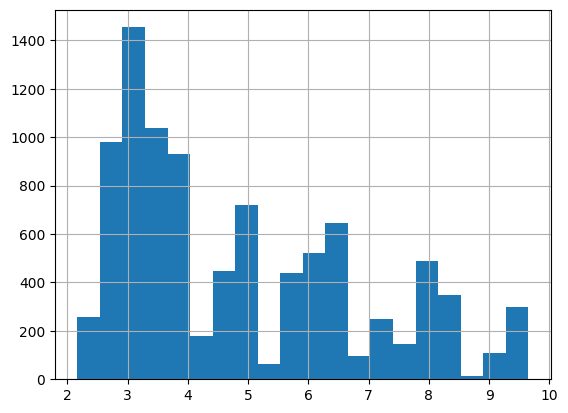

In [10]:
raw_data.loc[raw_data["current_port"]=="HAMBURG","ratio"].hist(bins=20)

<Axes: >

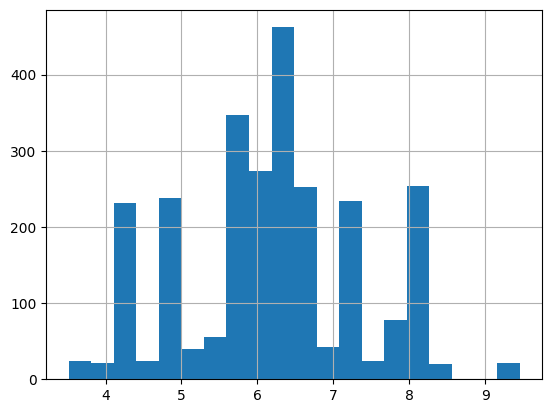

In [11]:
raw_data.loc[raw_data["current_port"]!="HAMBURG","ratio"].hist(bins=20)

<Axes: >

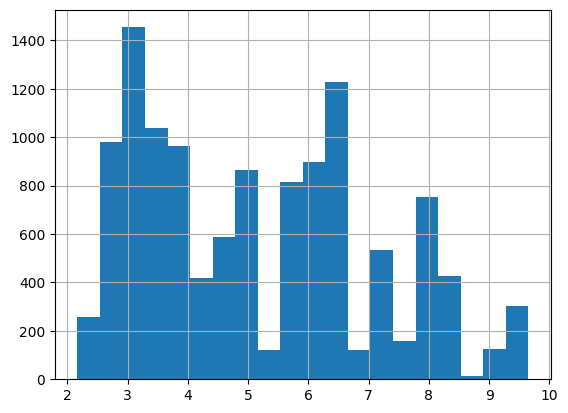

In [12]:
raw_data.loc[:,"ratio"].hist(bins=20)

size feature distribution

<Axes: >

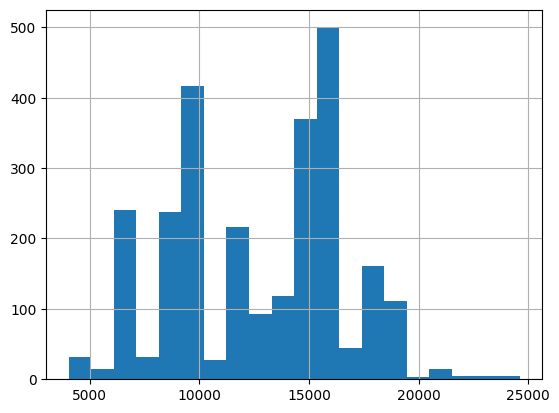

In [13]:
raw_data.loc[raw_data["current_port"]!="HAMBURG","size"].hist(bins=20)

In [14]:
raw_data.loc[raw_data["current_port"]!="HAMBURG",["size"]].describe()

,size
count,2643.000000
mean,12663.735663
std,3895.825909
min,4037.449600
25%,9470.020000
50%,14260.960000
75%,15489.600000
max,24609.846000


<Axes: >

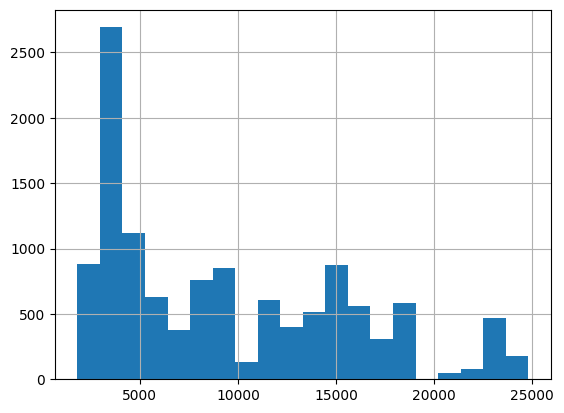

In [15]:
raw_data.loc[:,"size"].hist(bins=20)

clearly much different distribution per port

In [16]:
terminal_ham = raw_data.loc[raw_data["current_port"]=="HAMBURG", "current_terminal"].unique().tolist()
terminal_la = raw_data.loc[raw_data["current_port"]=="LOS ANGELES", "current_terminal"].unique().tolist()

In [17]:
def id2port(x, th, tl):
    if x["current_port"] == "HAMBURG":
        idx = th[x["current_terminal"]]
    else:
        idx = tl[x["current_terminal"]]
    return idx

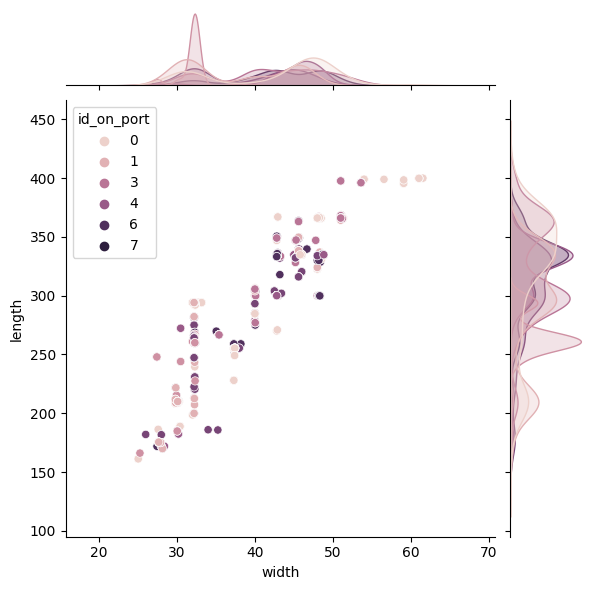

In [18]:
terminal_ham = {i:idx for idx, i in enumerate(terminal_ham)}
terminal_la = {i:idx for idx, i in enumerate(terminal_la)}
raw_data["id_on_port"] =  raw_data.apply(id2port, args=(terminal_ham, terminal_la), axis=1)
la_distribution = raw_data.loc[raw_data["current_port"]!="HAMBURG", ["width","length","size","id_on_port"]]
# Create hexbin plot with Seaborn
sns.jointplot(data=la_distribution, x="width",y="length",hue="id_on_port",)

# Show the plot
plt.show()

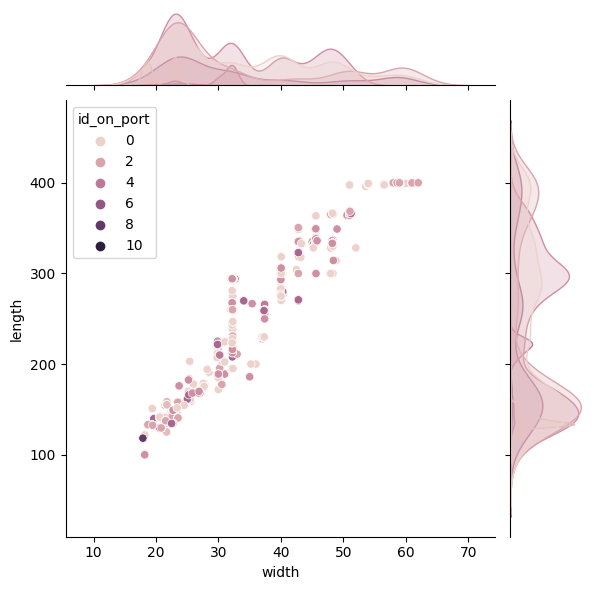

In [19]:
hamburg_distibution = raw_data.loc[raw_data["current_port"]=="HAMBURG", ["width","length","size","id_on_port"]]
# Create hexbin plot with Seaborn
sns.jointplot(data=hamburg_distibution, x="width",y="length",hue="id_on_port",  color="#4CB391")

# Show the plot
plt.show()

In [20]:
nu_cols = raw_data.select_dtypes(include=['float64','int64']).columns
print(nu_cols)

Index(['grt', 'teu', 'length', 'width', 'diff', 'ratio', 'foot_ratio', 'size',
       'id_on_port'],
      dtype='object')


In [21]:
# sns.pairplot(raw_data.loc[raw_data["current_port"]=="HAMBURG", nu_cols],hue="id_on_port", palette="Set2")

In [22]:
# sns.pairplot(raw_data.loc[raw_data["current_port"]!="HAMBURG", nu_cols],hue="id_on_port", palette="Set3")

# Construct baseline

#### use previous terminal as a prediction for the next

In [23]:
gather_results = dict()
gather_data = dict()

In [24]:
grouped_by_ship = raw_data.groupby(["shipname","current_port"])
restructure = []
matches = 0
for ship_no,(name,group) in enumerate(grouped_by_ship):
    restructure.append(group.sort_values(by="last_terminal_doc_timestamp"))
    restructure[-1].loc[:, "concat"] = restructure[-1].loc[:,"id_on_port"].astype(str) +"__" + restructure[-1].loc[:,"current_port"]
    restructure[-1].loc[:, "concat_s"] = restructure[-1].loc[:, "concat"].shift()
    tmp = restructure[-1].dropna()
    if tmp.dropna().shape[0]:
        matches += tmp.dropna().loc[restructure[-1]["concat"]==restructure[-1]["concat_s"], :].shape[0]
        

In [25]:
matches, raw_data.shape[0]

(7491, 12054)

In [26]:
matches/raw_data.shape[0] # this here is essentially the accuracy metric on the whole dataset.

0.6214534594325535

#### explanation of the main metrics that we will use since this problem is multi class classification problem.

Micro F1 and Macro F1 scores are two commonly used metrics to evaluate the performance of a multi-class classification model.

**Micro F1** score considers all the predictions and ground truth values from all classes, and gives an equal weight to each sample. This means that the overall F1 score is calculated by taking into account the total true positives, false positives, and false negatives across all classes. Micro F1 is useful when you want to put equal emphasis on each individual sample in the evaluation.

**Macro F1** score, on the other hand, calculates the F1 score for each class and takes the unweighted mean of the F1 scores. In this case, each class is given equal importance, regardless of the number of samples in each class. Macro F1 is useful when you care about the overall performance of the model across all classes, rather than the performance on individual samples.

In [27]:
restructure = pd.concat(restructure)
print(restructure.shape)

(12054, 18)


In [28]:
population = Counter(restructure["concat"])
pprint(sorted([(value,key) for key, value in population.items()]))
print("HAMBURG")
pprint(sorted([(value,key) for key, value in population.items() if "HAM" in key]))
print("LA")
pprint(sorted([(value,key) for key, value in population.items() if "HAM" not in key]))

[(1, '10__HAMBURG'),
 (1, '7__LOS ANGELES'),
 (1, '9__HAMBURG'),
 (9, '8__HAMBURG'),
 (28, '7__HAMBURG'),
 (40, '6__HAMBURG'),
 (157, '4__HAMBURG'),
 (225, '2__LOS ANGELES'),
 (266, '1__HAMBURG'),
 (271, '4__LOS ANGELES'),
 (323, '6__LOS ANGELES'),
 (355, '5__LOS ANGELES'),
 (469, '3__LOS ANGELES'),
 (485, '1__LOS ANGELES'),
 (514, '0__LOS ANGELES'),
 (1183, '5__HAMBURG'),
 (2313, '2__HAMBURG'),
 (2574, '0__HAMBURG'),
 (2839, '3__HAMBURG')]
HAMBURG
[(1, '10__HAMBURG'),
 (1, '9__HAMBURG'),
 (9, '8__HAMBURG'),
 (28, '7__HAMBURG'),
 (40, '6__HAMBURG'),
 (157, '4__HAMBURG'),
 (266, '1__HAMBURG'),
 (1183, '5__HAMBURG'),
 (2313, '2__HAMBURG'),
 (2574, '0__HAMBURG'),
 (2839, '3__HAMBURG')]
LA
[(1, '7__LOS ANGELES'),
 (225, '2__LOS ANGELES'),
 (271, '4__LOS ANGELES'),
 (323, '6__LOS ANGELES'),
 (355, '5__LOS ANGELES'),
 (469, '3__LOS ANGELES'),
 (485, '1__LOS ANGELES'),
 (514, '0__LOS ANGELES')]


In our case we have a clear majority classifier especially on 4 of the HAMBURG ports, but our main objective is not to
place the ships equally in the port but rather predict their true destination. Hence we will give very slightly more weight to micro f1.

In [29]:
print(restructure.shape[0])
restructure.loc[restructure["concat_s"].isna(), "concat_s"] = "no history"
print("macro f1",f1_score(restructure["concat"], restructure["concat_s"],average='macro'))
print("micro f1", f1_score(restructure["concat"], restructure["concat_s"],average='micro'))

12054
macro f1 0.47968322957434123
micro f1 0.6214534594325535


#### Next steps to reach the final solution

1. Verify/reject the markets team theory that historical data of the ship work.

2. Create more features by using polynomial ones in order to help catch a non linear relationship between the features and the actual label

3. In the procedure of solving the problem i will use essentially 11 possible labels max( 8 LA terminals + 11 HAMBURG terminals) and i will show all the increments before i reach my final result.
My final test will be on 19 labels.

4. Reduce the set of labels by introducing the "port" feature as a binary feature (since we have a priori knowledge). This way we could simplify the problem, and in the case of a missclassification it could easily be rectified with postprocessing

### we need to create the feature that keeps the history track of the ship

In [30]:
restructure.head(2)

,last_port,last_terminal,last_terminal_doc_timestamp,current_port,current_terminal,shipname,doc_timestamp,grt,teu,length,width,diff,ratio,foot_ratio,size,id_on_port,concat,concat_s
7497,SHANGHAI,Shanghai Mingdong Container Terminal,2021-09-08 06:13:00,LOS ANGELES,Everport Services Terminal,A DAISEN,2021-10-07 11:55:00,18326,1740,175.46,27.69,20520,3.771956,0.358136,4858.4874,4,4__LOS ANGELES,no history
9058,QINGDAO,QQCT,2022-01-12 07:56:00,LOS ANGELES,TraPac Terminal,A DAISEN,2022-02-17 11:00:00,18326,1740,175.46,27.69,11040,3.771956,0.358136,4858.4874,5,5__LOS ANGELES,4__LOS ANGELES


In [31]:
restructure["doc_timestamp"] = pd.to_datetime(restructure.loc[:, "doc_timestamp"])
restructure["last_terminal_doc_timestamp"] = pd.to_datetime(restructure.loc[:, "last_terminal_doc_timestamp"])

In [32]:
grouped_by_ship = restructure.groupby(["shipname"])
# here *we don't* need to groupby the port as well, we just need the historical data.
make_history = []
matches = 0
for ship_no,(name,group) in enumerate(grouped_by_ship):
    group = group.sort_values(by="last_terminal_doc_timestamp")    
    increment = list()
    historical_data = group.loc[:, "concat"].to_list()
    trajectory = list()
    number_of_trips = list(range(len(historical_data)))
    for item in historical_data:
        if not len(increment):
            trajectory.append(["no history"])
        else:
            trajectory.append([])
            trajectory[-1].extend(increment)
        increment.append(item)
    group["history"] = trajectory
    group["no_trips"] = number_of_trips
    trips_on_the_current_port = [1 if y[-1] in x[-1] else 0 for x,y in zip(trajectory, list(group["current_port"]))]
    tptp = [1 if y[-1] in x[-1] else 0 for x,y in zip(trajectory, list(group["current_port"]))]
#     group["trips_on_this_port"] = [sum(tptp[:idx]) for idx, i in enumerate(tptp,1)]
    
    sm = list()
    for i in trajectory:
        if "no history" in i[-1] and len(i)==1:
            sm.append(0)
        elif "no history" not in i:
            sm.append(len(set(i)))
    group["different_terminals"] = sm
    group["last_visit"] = ["no history" if "history" in i[-1] else i[-1] for i in trajectory]
    group["last_port_visit"] = group["concat_s"].copy()
    group["parallel"] = historical_data
    make_history.append(group)


make_history = pd.concat(make_history)
encoder = LabelEncoder()
make_history["parallel"] = encoder.fit_transform(make_history["parallel"])

In [33]:
make_history.head(2)

,last_port,last_terminal,last_terminal_doc_timestamp,current_port,current_terminal,shipname,doc_timestamp,grt,teu,length,...,size,id_on_port,concat,concat_s,history,no_trips,different_terminals,last_visit,last_port_visit,parallel
7497,SHANGHAI,Shanghai Mingdong Container Terminal,2021-09-08 06:13:00,LOS ANGELES,Everport Services Terminal,A DAISEN,2021-10-07 11:55:00,18326,1740,175.46,...,4858.4874,4,4__LOS ANGELES,no history,[no history],0,0,no history,no history,10
9058,QINGDAO,QQCT,2022-01-12 07:56:00,LOS ANGELES,TraPac Terminal,A DAISEN,2022-02-17 11:00:00,18326,1740,175.46,...,4858.4874,5,5__LOS ANGELES,4__LOS ANGELES,[4__LOS ANGELES],1,1,4__LOS ANGELES,4__LOS ANGELES,12


now we effectively/easily use this dataset or a subset of it (we don't need ALL the features anymore) and tackle this as a timeseries problem.

as we said before it is important to have the port as a feature since we're expected to know the port the ship is going

In [34]:
make_history["current_port"] = make_history.apply(lambda x: 0 if "HAM" in x["current_port"] else 1,axis=1)

the last ports and the last terminals don't actually matter. What actually matters is the difference between the current port call and the previous port call.

In [35]:
backup_history = make_history.copy()
enc = OrdinalEncoder()
make_history.loc[:, ["shipname"]] = enc.fit_transform(make_history.loc[:, ["shipname"]])

In [36]:
one_hot = pd.get_dummies(make_history.loc[:, "last_visit"])
one_hot_columns = list(one_hot.columns)

one_hot_2 = pd.get_dummies(make_history.loc[:, "last_port_visit"])
one_hot_2 = one_hot_2.add_suffix("oh2")
one_hot_columns_2 = list(one_hot_2.columns)


extra_columns = one_hot_columns +  one_hot_columns_2

make_history = pd.concat([make_history, one_hot, one_hot_2],axis=1)


this WILL NOT BE USED AS A FEATURE but rather as a medium to be able to process the data a bit easier

the shipname cannot be possibly used as a feature because
it will create curse of dimentonality since we can only use one hot
representations. Unless of course we could use ship embeddings (which would)
take a bigger dataset.

In [37]:
make_history.loc[:, "last_visit"].unique()

array(['no history', '4__LOS ANGELES', '5__LOS ANGELES', '0__HAMBURG',
       '7__HAMBURG', '2__HAMBURG', '5__HAMBURG', '3__HAMBURG',
       '6__HAMBURG', '1__HAMBURG', '3__LOS ANGELES', '6__LOS ANGELES',
       '2__LOS ANGELES', '0__LOS ANGELES', '8__HAMBURG', '1__LOS ANGELES',
       '4__HAMBURG', '10__HAMBURG', '7__LOS ANGELES'], dtype=object)

In [38]:
make_history.head(2)

,last_port,last_terminal,last_terminal_doc_timestamp,current_port,current_terminal,shipname,doc_timestamp,grt,teu,length,...,4__HAMBURGoh2,4__LOS ANGELESoh2,5__HAMBURGoh2,5__LOS ANGELESoh2,6__HAMBURGoh2,6__LOS ANGELESoh2,7__HAMBURGoh2,7__LOS ANGELESoh2,8__HAMBURGoh2,no historyoh2
7497,SHANGHAI,Shanghai Mingdong Container Terminal,2021-09-08 06:13:00,1,Everport Services Terminal,0.0,2021-10-07 11:55:00,18326,1740,175.46,...,0,0,0,0,0,0,0,0,0,1
9058,QINGDAO,QQCT,2022-01-12 07:56:00,1,TraPac Terminal,0.0,2022-02-17 11:00:00,18326,1740,175.46,...,0,1,0,0,0,0,0,0,0,0


In [39]:
make_history = make_history.sort_values(by="doc_timestamp")

In [40]:
make_history["quarter"] = make_history.loc[:, "doc_timestamp"].dt.quarter
make_history["day of week"] = make_history.loc[:, "doc_timestamp"].dt.dayofweek

In [41]:
X_train_main, X_test_main, y_train, y_test= train_test_split(make_history.loc[:,make_history.columns!="id_on_port"], make_history.loc[:,["id_on_port"]], test_size=0.2, shuffle=False)

                                                             
y_train_main = y_train.copy()
y_test_main = y_test.copy()

X_train_main and X_test_main is a superset of all the features so we can run with any subset. The whole dataset is splitted in a way to solve as a timeseries problem per ship (even if we don't use the ship as a feature)

In [42]:
ft = ['no_trips','current_port', 'grt', 'teu', 'length', 'width', 'diff', 'ratio', 'size', 'different_terminals','foot_ratio']
print(f" features used: {ft}")

X_train = X_train_main.loc[:, ft].copy()
X_test = X_test_main.loc[:, ft].copy()

 features used: ['no_trips', 'current_port', 'grt', 'teu', 'length', 'width', 'diff', 'ratio', 'size', 'different_terminals', 'foot_ratio']


In [43]:
X_train.loc[:, ft].describe()

,no_trips,current_port,grt,teu,length,width,diff,ratio,size,different_terminals,foot_ratio
count,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000
mean,13.181582,0.221612,60344.435342,5496.633828,244.016730,34.687520,44429.362232,5.154590,9463.432512,1.935601,0.466751
std,18.602684,0.415353,57189.271803,5378.645649,89.819422,11.581588,25123.569085,1.899528,6238.275144,1.519663,0.180117
min,0.000000,0.000000,3992.000000,508.000000,99.950000,17.900000,0.000000,2.168469,1819.090000,0.000000,0.205248
25%,2.000000,0.000000,11550.000000,1036.000000,154.520000,23.530000,22740.000000,3.300595,3710.610200,1.000000,0.292014
50%,6.000000,0.000000,40146.000000,4000.000000,259.000000,32.200000,46020.000000,4.926964,8404.530000,1.000000,0.457603
75%,16.000000,0.000000,95680.000000,8566.000000,332.150000,45.600000,65730.000000,6.425343,14470.552800,3.000000,0.577871
max,115.000000,1.000000,236583.000000,23992.000000,400.000000,62.000000,86340.000000,9.650985,24800.000000,6.000000,0.982377


### phase 2 of experiments with these features

# logistic regression

In [44]:
model = LogisticRegression(random_state=42)

svt = RobustScaler()

model.fit(svt.fit_transform(X_train),y_train)

svtest = RobustScaler()

y_pred = model.predict(svtest.fit_transform(X_test))

print("micro", f1_score(y_pred,y_test,average='micro'))
print("macro", f1_score(y_pred,y_test,average='macro'))
print(classification_report(y_pred.ravel(),y_test.values.ravel()))

gather_results["lr_ft"] = ({"micro f1":f1_score(y_pred,y_test,average='micro'), "macro":f1_score(y_pred,y_test,average='macro')})

gather_data["lr_ft"] = {"X_train":pd.DataFrame(svt.fit_transform(X_train), columns=X_train.columns),"y_train":y_train,"X_test":pd.DataFrame(svtest.fit_transform(X_test),columns=X_test.columns),"y_test":y_test,"model":model, "y_pred":y_pred}


micro 0.30070510161758607
macro 0.12653729239477268
              precision    recall  f1-score   support

           0       0.53      0.26      0.35      1108
           1       0.15      0.23      0.18        96
           2       0.27      0.36      0.31       370
           3       0.40      0.35      0.37       775
           4       0.02      0.07      0.03        27
           5       0.01      0.09      0.02        35
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0

    accuracy                           0.30      2411
   macro avg       0.14      0.14      0.13      2411
weighted avg       0.42      0.30      0.34      2411



# Random Forest Classifier

micro 0.6391538780588967
macro 0.4558013907275737
              precision    recall  f1-score   support

           0       0.67      0.65      0.66       575
           1       0.77      0.67      0.71       165
           2       0.61      0.52      0.56       594
           3       0.71      0.73      0.72       673
           4       0.63      0.81      0.71        69
           5       0.45      0.60      0.51       265
           6       0.67      0.70      0.69        70
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0

    accuracy                           0.64      2411
   macro avg       0.45      0.47      0.46      2411
weighted avg       0.65      0.64      0.64      2411



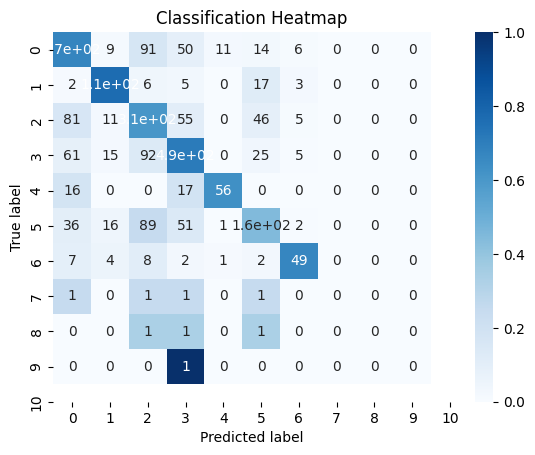

In [45]:
model = RandomForestClassifier(random_state=42)

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

print("micro", f1_score(y_pred, y_test.values.ravel(),average='micro'))
print("macro", f1_score(y_pred, y_test.values.ravel(),average='macro'))
print(classification_report(y_pred.ravel(),y_test.values.ravel()))
gather_results["rfr_ft"] = {"micro f1":f1_score(y_pred,y_test,average='micro'), "macro":f1_score(y_pred,y_test,average='macro')}

gather_data["rfr_ft"] = {"X_train":X_train,"y_train":y_train,"X_test":X_test,"y_test":y_test,"model":model, "y_pred":y_pred}

heatmap(y_test, y_pred)

In [46]:
check_df = pd.DataFrame(model.feature_importances_.reshape(1,-1), columns=X_train.columns).T
check_df.columns = ["importance"]

In [47]:
check_df.sort_values(by="importance")

,importance
current_port,0.031988
different_terminals,0.058318
width,0.062654
teu,0.079737
foot_ratio,0.083193
length,0.086262
size,0.087548
grt,0.087890
ratio,0.092397
diff,0.164952


# SVC

micro 0.35835752799668186
macro 0.17336512252937125
              precision    recall  f1-score   support

           0       0.47      0.30      0.37       862
           1       0.25      0.67      0.37        54
           2       0.69      0.34      0.46      1007
           3       0.31      0.49      0.38       434
           4       0.02      0.14      0.04        14
           5       0.00      0.04      0.01        28
           6       0.07      0.42      0.12        12
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0

    accuracy                           0.36      2411
   macro avg       0.18      0.24      0.17      2411
weighted avg       0.52      0.36      0.40      2411



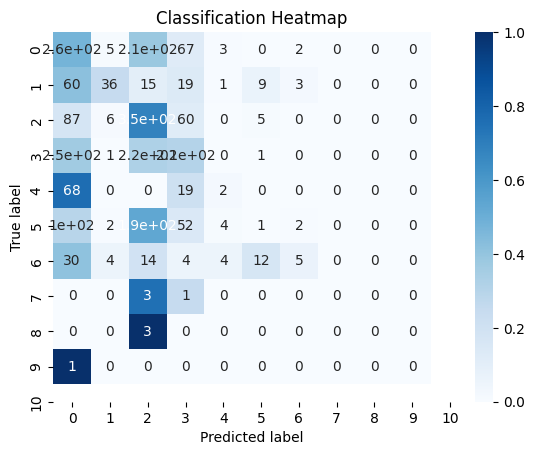

In [48]:
# SVMs' need scaling before used.
model = SVC(random_state=42)


svt = RobustScaler()

model.fit(svt.fit_transform(X_train),y_train)

svtest = RobustScaler()

y_pred = model.predict(svtest.fit_transform(X_test))

print("micro", f1_score(y_pred.ravel(),y_test.values.ravel(),average='micro'))
print("macro", f1_score(y_pred.ravel(),y_test.values.ravel(),average='macro'))
print(classification_report(y_pred.ravel(),y_test.values.ravel()))
gather_results["svm_ft"] = {"micro f1":f1_score(y_pred,y_test,average='micro'), "macro":f1_score(y_pred,y_test,average='macro')}


gather_data["svm_ft"] = {"X_train":pd.DataFrame(svt.fit_transform(X_train), columns=X_train.columns),"y_train":y_train,"X_test":pd.DataFrame(svtest.fit_transform(X_test), columns=X_test.columns),"y_test":y_test,"model":model, "y_pred":y_pred}

heatmap(y_test, y_pred)

In [49]:
checking_df = pd.concat([X_test,y_test],axis=1)

In [50]:
checking_df.loc[(checking_df["current_port"]==1) & (checking_df["id_on_port"]>7),:]

,no_trips,current_port,grt,teu,length,width,diff,ratio,size,different_terminals,foot_ratio,id_on_port


In the case of misclassification for terminals over the 9th (i.e. for LA) we could correct the prediction by placing them to other 8 terminals.

1. This could happen in multiple ways, either by using the knowledge of the prior distribution and place the prediction of over 8th terminal to the most visited terminal of the correct port.
2. If we had information about the terminals (aka similiarties of the terminals i would try to correlate the 9 to 11 terminals to one of the other 8.

Since this is not the case here, we can't perform any post processing right now


# compare with baseline on the same validation set.

In [51]:
restructure2 = restructure.loc[restructure.index.isin(X_test.index), :].copy()
print(restructure2.shape[0])
print("macro f1",f1_score(restructure2["concat"], restructure2["concat_s"],average='macro'))
print("micro f1", f1_score(restructure2["concat"], restructure2["concat_s"],average='micro'))

gather_results["base_vali"] = {"micro f1":f1_score(restructure2["concat"], restructure2["concat_s"],average='micro'), "macro":f1_score(restructure2["concat"], restructure2["concat_s"],average='macro')}

print(classification_report(restructure2["concat_s"], restructure2["concat"]))

2411
macro f1 0.5760643611534638
micro f1 0.6818747407714641
                precision    recall  f1-score   support

    0__HAMBURG       0.64      0.70      0.67       415
0__LOS ANGELES       0.76      0.88      0.82        89
   10__HAMBURG       0.00      0.00      0.00         1
    1__HAMBURG       0.88      0.88      0.88        42
1__LOS ANGELES       0.81      0.93      0.87        88
    2__HAMBURG       0.57      0.60      0.59       444
2__LOS ANGELES       0.84      0.91      0.87        34
    3__HAMBURG       0.73      0.75      0.74       588
3__LOS ANGELES       0.94      1.00      0.97        80
    4__HAMBURG       0.89      0.94      0.91        33
4__LOS ANGELES       0.81      0.86      0.84        51
    5__HAMBURG       0.57      0.58      0.57       281
5__LOS ANGELES       0.85      0.83      0.84        70
    6__HAMBURG       0.00      0.00      0.00        13
6__LOS ANGELES       0.71      0.91      0.80        46
    7__HAMBURG       0.00      0.00      0

In [52]:
restructure2.loc[restructure2["concat_s"]=="no history",:].head(2)

,last_port,last_terminal,last_terminal_doc_timestamp,current_port,current_terminal,shipname,doc_timestamp,grt,teu,length,width,diff,ratio,foot_ratio,size,id_on_port,concat,concat_s
12036,NINGBO,Daxie China Merchants ICT,2022-11-05 05:47:00,LOS ANGELES,TraPac Terminal,A.IDEFIX,2022-11-23 12:04:00,18263,1700,182.00,26.00,22620,3.859467,0.359256,4732.0000,5,5__LOS ANGELES,no history
10953,FELIXSTOWE,Trinity Container Terminal,2022-08-08 20:01:00,HAMBURG,HHLA Container Terminal Tollerort,AS CONSTANTINA,2022-08-10 20:01:00,27786,2700,221.69,29.86,0,4.197494,0.407876,6619.6634,5,5__HAMBURG,no history


one of the reasons that we get a better result from the baseline is that we do have a majority classifier on our hands 

# Evidently we need to explore new features

first of all we must definitely should use the last_known terminal
hence veifying the hypothesis of the product team.

In [53]:
X_train_main.shape

(9643, 63)

In [54]:
X_train_main.loc[X_train_main["last_visit"]=="no history",:].head(2)

,last_port,last_terminal,last_terminal_doc_timestamp,current_port,current_terminal,shipname,doc_timestamp,grt,teu,length,...,5__HAMBURGoh2,5__LOS ANGELESoh2,6__HAMBURGoh2,6__LOS ANGELESoh2,7__HAMBURGoh2,7__LOS ANGELESoh2,8__HAMBURGoh2,no historyoh2,quarter,day of week
0,BREMERHAVEN,North Sea Terminal,2020-01-02 16:12:00,0,Eurogate Container Terminal Hamburg,552.0,2020-01-03 06:20:00,17488,1421,168.11,...,0,0,0,0,0,0,0,1,1,4
1,TILBURY,London Container Terminal,2020-01-01 21:56:00,0,C. Steinweg Multipurpose Terminal,558.0,2020-01-03 07:45:00,9981,868,134.40,...,0,0,0,0,0,0,0,1,1,4


In [55]:
X_train_main.loc[X_train_main["last_visit"]=="no history",:].shape[0],X_test_main.loc[X_test_main["last_visit"]=="no history",:].shape[0]

(1288, 109)

should i use the previous lag i would have to delete 1288 rows out of the dataset since they don't actually have history, instead i have decided to make that a feature.

In [56]:
expanded_cols = ft.copy()
expanded_cols.extend(one_hot_columns)
expanded_cols.extend(one_hot_columns_2)
X_train = X_train_main.loc[:, expanded_cols].copy()
X_test = X_test_main.loc[:, expanded_cols].copy()

### Logistic regression with expanded set of features.

micro 0.6827042720862713
macro 0.4994540306883229
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       590
           1       0.84      0.88      0.86       136
           2       0.49      0.58      0.53       432
           3       0.77      0.70      0.73       763
           4       0.84      0.84      0.84        89
           5       0.62      0.62      0.62       352
           6       0.58      0.86      0.69        49
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0

    accuracy                           0.68      2411
   macro avg       0.49      0.52      0.50      2411
weighted avg       0.69      0.68      0.69      2411



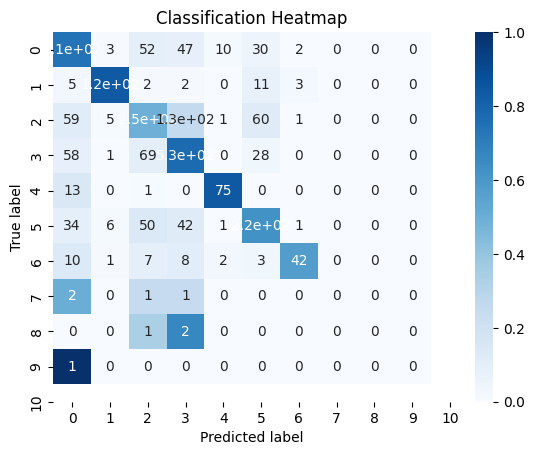

In [57]:
model = LogisticRegression(random_state=42)

svt = RobustScaler()

model.fit(svt.fit_transform(X_train),y_train)

svtest = RobustScaler()

y_pred = model.predict(svtest.fit_transform(X_test))

print("micro", f1_score(y_pred,y_test,average='micro'))
print("macro", f1_score(y_pred,y_test,average='macro'))
print(classification_report(y_pred.ravel(),y_test.values.ravel()))

gather_results["lr_expanded"] = {"micro f1":f1_score(y_pred,y_test,average='micro'), "macro":f1_score(y_pred,y_test,average='macro')}

gather_data["lr_expanded"] = {"X_train":pd.DataFrame(svt.fit_transform(X_train),columns=X_train.columns),"y_train":y_train,"X_test":pd.DataFrame(svtest.fit_transform(X_test),columns=X_test.columns),"y_test":y_test,"model":model, "y_pred":y_pred}

heatmap(y_test, y_pred)

### RandomForestClassifier with expanded set of features.

micro 0.671505599336375
macro 0.4759327677780262
              precision    recall  f1-score   support

           0       0.71      0.70      0.70       559
           1       0.83      0.85      0.84       139
           2       0.61      0.53      0.57       575
           3       0.74      0.73      0.74       699
           4       0.53      0.77      0.63        61
           5       0.57      0.64      0.60       313
           6       0.63      0.75      0.69        61
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0

    accuracy                           0.67      2411
   macro avg       0.46      0.50      0.48      2411
weighted avg       0.67      0.67      0.67      2411



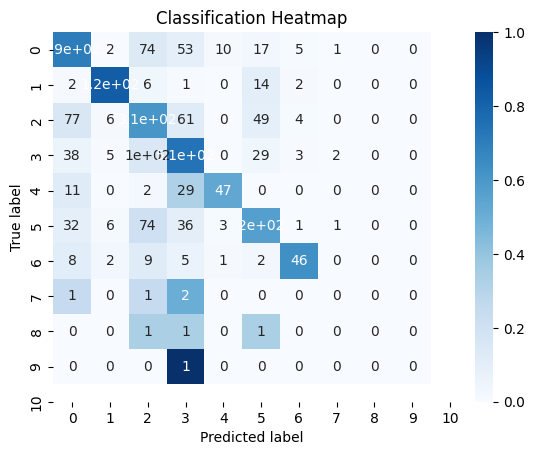

In [58]:
model = RandomForestClassifier(random_state=42)

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

print("micro", f1_score(y_pred, y_test.values.ravel(),average='micro'))
print("macro", f1_score(y_pred, y_test.values.ravel(),average='macro'))
print(classification_report(y_pred.ravel(),y_test.values.ravel()))
gather_results["rfr_expanded"] = {"micro f1":f1_score(y_pred,y_test,average='micro'), "macro":f1_score(y_pred,y_test,average='macro')}

gather_data["rfr_expanded"] = {"X_train":X_train,"y_train":y_train,"X_test":X_test,"y_test":y_test,"model":model, "y_pred":y_pred}

heatmap(y_test, y_pred)

<Axes: title={'center': 'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

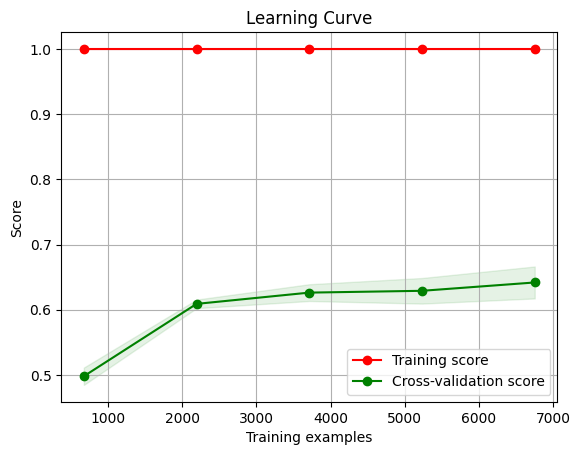

In [59]:
md = RandomForestClassifier(random_state=42)
tscv = TimeSeriesSplit(n_splits=3, test_size=round(0.1*len(X_train)))

plot_learning_curve(md, X=X_train, y=y_train, scoring='f1_micro', cv=tscv, shuffle=False)


##### it seems that with more training examples the model actually learns.

### SVMClassifier with expanded set of features.

micro 0.708834508502696
macro 0.5167490929756532
              precision    recall  f1-score   support

           0       0.75      0.68      0.71       604
           1       0.83      0.92      0.87       130
           2       0.63      0.59      0.61       545
           3       0.77      0.77      0.77       687
           4       0.84      0.89      0.87        84
           5       0.59      0.68      0.63       306
           6       0.62      0.82      0.70        55
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0

    accuracy                           0.71      2411
   macro avg       0.50      0.53      0.52      2411
weighted avg       0.71      0.71      0.71      2411



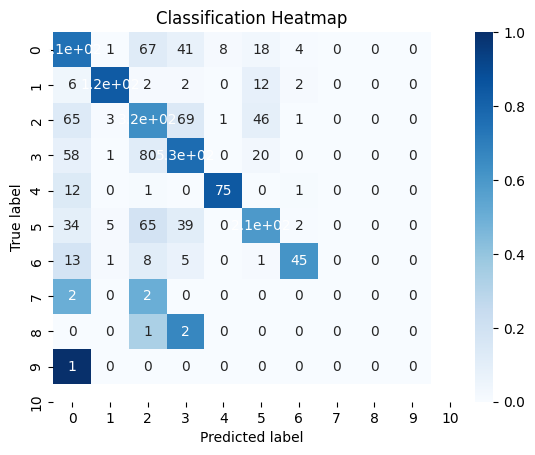

In [60]:
# SVMs' need scaling before used.
model = SVC(random_state=42)


svt = RobustScaler()

model.fit(svt.fit_transform(X_train),y_train)

svtest = RobustScaler()

y_pred = model.predict(svtest.fit_transform(X_test))

print("micro", f1_score(y_pred.ravel(),y_test.values.ravel(),average='micro'))
print("macro", f1_score(y_pred.ravel(),y_test.values.ravel(),average='macro'))
print(classification_report(y_pred.ravel(),y_test.values.ravel()))
gather_results["svm_expanded"] = {"micro f1":f1_score(y_pred,y_test,average='micro'), "macro":f1_score(y_pred,y_test,average='macro')}

gather_data["svm_expanded"] = {"X_train":pd.DataFrame(svt.fit_transform(X_train),columns=X_train.columns),"y_train":y_train,"X_test":pd.DataFrame(svtest.fit_transform(X_test), columns=X_test.columns),"y_test":y_test,"model":model, "y_pred":y_pred}

heatmap(y_test, y_pred)

All of those models could use hyperparameter tuning by using GridSearchCV (with tscv since we have a timeseries). But i thought it would make more sense to produce more features in order to get more insights for the problem.

The EDA process is more valuable whereas tuning could be fully automated and it is takes time.

We can expand our feature search a bit more by using Polynomial features (without the bias) and clustering of the features
to give us an extra insight for data of our ships




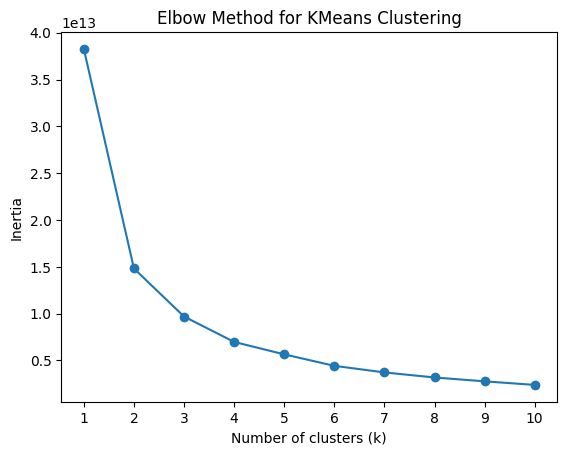

In [61]:
# Create a list of inertia values for different k values
inertias = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train)
    inertias.append(kmeans.inertia_)

# Plot the elbow graph
plt.plot(k_values, inertias, '-o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for KMeans Clustering')
plt.xticks(np.arange(1, 11))
plt.show()

as we can see from the plot the best number of clusters seems to be number 3 (it looks more like an elbow).

In [62]:
print(X_train_main.shape,y_train_main.shape)

kmeans = KMeans(n_clusters=3, random_state=42)
res = kmeans.fit_predict(X_train)
X_train["res"] = res

tmp1 = pd.get_dummies(X_train["res"])
tmp1 = tmp1.add_suffix("oh2")

X_train = pd.concat([X_train,tmp1],axis=1)
del X_train["res"]

res = kmeans.predict(X_test)
X_test["res"] = res
tmp2 = pd.get_dummies(X_test["res"])
tmp2 = tmp2.add_suffix("oh2")
X_test = pd.concat([X_test,tmp2],axis=1)
del X_test["res"]

model = RandomForestClassifier(random_state=42)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

print("micro", f1_score(y_pred, y_test.values.ravel(),average='micro'))
print("macro", f1_score(y_pred, y_test.values.ravel(),average='macro'))
print(classification_report(y_pred.ravel(),y_test.values.ravel()))
gather_results["rfr_cluster"] = {"micro f1":f1_score(y_pred,y_test,average='micro'), "macro":f1_score(y_pred,y_test,average='macro')}


gather_data["rfr_cluster"] = {"X_train":X_train,"y_train":y_train,"X_test":X_test,"y_test":y_test,"model":model, "y_pred":y_pred}


(9643, 63) (9643, 1)
micro 0.6681874740771464
macro 0.47526668983423265
              precision    recall  f1-score   support

           0       0.70      0.69      0.69       565
           1       0.83      0.84      0.83       141
           2       0.60      0.53      0.56       566
           3       0.74      0.73      0.73       698
           4       0.54      0.76      0.63        63
           5       0.56      0.63      0.59       315
           6       0.64      0.77      0.70        61
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0

    accuracy                           0.67      2411
   macro avg       0.46      0.50      0.48      2411
weighted avg       0.67      0.67      0.67      2411



Same test for polynomial features. The polynomial features help in capturing non linear relationships.


### add Polynomial features + one hot encoding features + clusters

In [63]:
print("features used")
pprint(list(X_test.columns))
degree = 2

# Create a PolynomialFeatures object
poly = PolynomialFeatures(degree, include_bias=False)

# Fit and transform the training data
X_train_poly = poly.fit_transform(X_train.loc[:, ft])

X_train_poly = pd.concat([pd.DataFrame(X_train_poly).reset_index(drop=True),X_train.loc[:, extra_columns].reset_index(drop=True),tmp1.reset_index(drop=True)],axis=1)
X_train_poly.columns = [f"lala_{i}" for i in list(X_train_poly.columns)]
# Transform the test data using the same polynomial features
X_test_poly = poly.transform(X_test.loc[:, ft])
X_test_poly = pd.concat([pd.DataFrame(X_test_poly),X_test.loc[:, extra_columns].reset_index(drop=True),tmp2.reset_index(drop=True)],axis=1)
X_test_poly.columns = X_train_poly.columns
model = RandomForestClassifier(random_state=42)
print(X_train_poly.shape)
model.fit(X_train_poly,y_train.astype(float))

y_pred = model.predict(X_test_poly)

print("micro", f1_score(y_pred, y_test.values.ravel(),average='micro'))
print("macro", f1_score(y_pred, y_test.values.ravel(),average='macro'))
print(classification_report(y_pred.ravel(),y_test.values.ravel()))
gather_results["rfr_poly_cluster_expanded"] = {"micro f1":f1_score(y_pred,y_test,average='micro'), "macro":f1_score(y_pred,y_test,average='macro')}



gather_data["rfr_poly_cluster_expanded"] = {"X_train":X_train_poly,"y_train":y_train,"X_test":X_test_poly,"y_test":y_test,"model":model, "y_pred":y_pred}


features used
['no_trips',
 'current_port',
 'grt',
 'teu',
 'length',
 'width',
 'diff',
 'ratio',
 'size',
 'different_terminals',
 'foot_ratio',
 '0__HAMBURG',
 '0__LOS ANGELES',
 '10__HAMBURG',
 '1__HAMBURG',
 '1__LOS ANGELES',
 '2__HAMBURG',
 '2__LOS ANGELES',
 '3__HAMBURG',
 '3__LOS ANGELES',
 '4__HAMBURG',
 '4__LOS ANGELES',
 '5__HAMBURG',
 '5__LOS ANGELES',
 '6__HAMBURG',
 '6__LOS ANGELES',
 '7__HAMBURG',
 '7__LOS ANGELES',
 '8__HAMBURG',
 'no history',
 '0__HAMBURGoh2',
 '0__LOS ANGELESoh2',
 '10__HAMBURGoh2',
 '1__HAMBURGoh2',
 '1__LOS ANGELESoh2',
 '2__HAMBURGoh2',
 '2__LOS ANGELESoh2',
 '3__HAMBURGoh2',
 '3__LOS ANGELESoh2',
 '4__HAMBURGoh2',
 '4__LOS ANGELESoh2',
 '5__HAMBURGoh2',
 '5__LOS ANGELESoh2',
 '6__HAMBURGoh2',
 '6__LOS ANGELESoh2',
 '7__HAMBURGoh2',
 '7__LOS ANGELESoh2',
 '8__HAMBURGoh2',
 'no historyoh2',
 '0oh2',
 '1oh2',
 '2oh2']
(9643, 118)
micro 0.6752384902530071
macro 0.47844390742156706
              precision    recall  f1-score   support

         0.0  

### add Polynomial features + one hot encoding features


In [64]:
degree = 2

# Create a PolynomialFeatures object
poly = PolynomialFeatures(degree, include_bias=False)

# Fit and transform the training data
X_train_poly = poly.fit_transform(X_train.loc[:, ft])

X_train_poly = pd.concat([pd.DataFrame(X_train_poly).reset_index(drop=True),X_train.loc[:, extra_columns].reset_index(drop=True)],axis=1)
X_train_poly.columns = [f"lala_{i}" for i in list(X_train_poly.columns)]
# Transform the test data using the same polynomial features
X_test_poly = poly.transform(X_test.loc[:, ft])
X_test_poly = pd.concat([pd.DataFrame(X_test_poly),X_test.loc[:, extra_columns].reset_index(drop=True)],axis=1)
X_test_poly.columns = X_train_poly.columns
model = RandomForestClassifier(random_state=42)
print(X_train_poly.shape)
model.fit(X_train_poly,y_train.astype(float))

y_pred = model.predict(X_test_poly)

print("micro", f1_score(y_pred, y_test.values.ravel(),average='micro'))
print("macro", f1_score(y_pred, y_test.values.ravel(),average='macro'))
print(classification_report(y_pred.ravel(),y_test.values.ravel()))
gather_results["rfr_expanded_poly"] = {"micro f1":f1_score(y_pred,y_test,average='micro'), "macro":f1_score(y_pred,y_test,average='macro')}

gather_data["rfr_expanded_poly"] = {"X_train":X_train_poly,"y_train":y_train,"X_test":X_test_poly,"y_test":y_test,"model":model, "y_pred":y_pred}


(9643, 115)
micro 0.6756532559104106
macro 0.4775936864409531
              precision    recall  f1-score   support

         0.0       0.69      0.73      0.71       516
         1.0       0.82      0.87      0.84       135
         2.0       0.64      0.54      0.59       603
         3.0       0.75      0.71      0.73       729
         4.0       0.51      0.78      0.61        58
         5.0       0.57      0.65      0.61       310
         6.0       0.63      0.77      0.69        60
         7.0       0.00      0.00      0.00         0
         8.0       0.00      0.00      0.00         0
        10.0       0.00      0.00      0.00         0

    accuracy                           0.68      2411
   macro avg       0.46      0.50      0.48      2411
weighted avg       0.68      0.68      0.68      2411



# Finally we can perform feature selection

Using backward and forward elimination we can get the best subset of features that we can use. The thing is this procedure is extremely computationally expensive and i didn't manage the get the result of those functions.

In [65]:
def backward_elimination(X, y, model, metric):
    best_features = list(X.columns)
    best_score = 0
    
    for k in tqdm(range(1, len(X.columns) + 1)):
        for subset in combinations(X.columns, k):
            model.fit(X.loc[:, list(subset)], y)
            y_pred = model.predict(X[list(subset)])
            score = metric(y, y_pred.ravel(), average='macro')
            
            if score > best_score:
                best_score = score
                best_features = list(subset)
                
    return best_features

def forward_selection(X, y, model, metric):
    best_features = []
    best_score = 0
    
    for k in tqdm(range(1, len(X.columns) + 1)):
        if k == 1:
            candidate_features = list(X.columns)
        else:
            candidate_features = [f for f in X.columns if f not in best_features]
        
        for feature in candidate_features:
            model.fit(X[best_features + [feature]], y)
            y_pred = model.predict(X[best_features + [feature]])
            score = metric(y, y_pred.ravel(), average='macro')
            
            if score > best_score:
                best_score = score
                best_features.append(feature)
                
    return best_features

### the product theory has been verified that the historical data been extremely useful on the next prediction.

In [66]:
# put example of non timeseries data here.

In [67]:
raw_data.columns

Index(['last_port', 'last_terminal', 'last_terminal_doc_timestamp',
       'current_port', 'current_terminal', 'shipname', 'doc_timestamp', 'grt',
       'teu', 'length', 'width', 'diff', 'ratio', 'foot_ratio', 'size',
       'id_on_port'],
      dtype='object')

In [68]:
raw_data.head(2)

,last_port,last_terminal,last_terminal_doc_timestamp,current_port,current_terminal,shipname,doc_timestamp,grt,teu,length,width,diff,ratio,foot_ratio,size,id_on_port
0,BREMERHAVEN,North Sea Terminal,2020-01-02 16:12:00,HAMBURG,Eurogate Container Terminal Hamburg,HEINRICH EHLER,2020-01-03 06:20:00,17488,1421,168.11,26.80,50880,3.881609,0.315403,4505.348,0
1,TILBURY,London Container Terminal,2020-01-01 21:56:00,HAMBURG,C. Steinweg Multipurpose Terminal,HENNEKE RAMBOW,2020-01-03 07:45:00,9981,868,134.40,22.74,35340,3.265760,0.284008,3056.256,1


In [69]:
raw_data["concat"] = raw_data["current_port"] + raw_data["current_terminal"]

X = restructure.loc[:, ["grt","teu","length", "width", "diff", "ratio"]].copy()
Y = restructure.loc[:, ["concat"]].copy()

encoder = LabelEncoder()
Y = encoder.fit_transform(Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print("micro f1",f1_score(y_test, y_pred, average="micro"))
print("macro f1",f1_score(y_test, y_pred, average="macro"))

micro f1 0.5897967648278722
macro f1 0.47093253429270754


In [70]:
# keep the indices and compare with previous baseline

In [71]:
restructure = restructure.loc[restructure.index.isin(X_test.index), :]
print("micro f1", f1_score(restructure["concat_s"],restructure["concat"],average='micro' ))
print("macro f1",f1_score(restructure["concat_s"], restructure["concat"],average='macro' ))


micro f1 0.6163417669017005
macro f1 0.5372598718561064


In [72]:
X_test.shape, restructure.shape

((2411, 6), (2411, 18))

In [73]:
print(classification_report(restructure["concat_s"], restructure["concat"]))

                precision    recall  f1-score   support

    0__HAMBURG       0.62      0.71      0.67       466
0__LOS ANGELES       0.73      0.92      0.81        72
    1__HAMBURG       0.78      0.91      0.84        46
1__LOS ANGELES       0.68      0.90      0.78        72
    2__HAMBURG       0.52      0.56      0.54       420
2__LOS ANGELES       0.71      0.97      0.82        31
    3__HAMBURG       0.64      0.69      0.66       509
3__LOS ANGELES       0.83      0.99      0.90        81
    4__HAMBURG       0.87      0.90      0.89        30
4__LOS ANGELES       0.64      0.94      0.76        36
    5__HAMBURG       0.51      0.60      0.55       219
5__LOS ANGELES       0.69      0.82      0.75        66
    6__HAMBURG       0.00      0.00      0.00         6
6__LOS ANGELES       0.60      0.81      0.69        43
    7__HAMBURG       0.00      0.00      0.00        12
    8__HAMBURG       0.00      0.00      0.00         2
    9__HAMBURG       0.00      0.00      0.00  

# labels distribution (full dataset)

0. (1, '10HAMBURG')
1. (1, '7LOS ANGELES')
2. (1, '9HAMBURG')
3. (9, '8HAMBURG')
4. (28, '7HAMBURG')
5. (40, '6HAMBURG')
6. (157, '4HAMBURG')
7. (225, '2LOS ANGELES')
8. (266, '1HAMBURG')
9. (271, '4LOS ANGELES')
10. (323, '6LOS ANGELES')
11. (355, '5LOS ANGELES')
12. (469, '3LOS ANGELES')
13. (485, '1LOS ANGELES')
14. (514, '0LOS ANGELES')
15. (1183, '5HAMBURG')
16. (2313, '2HAMBURG')
17. (2574, '0HAMBURG')
18. (2839, '3HAMBURG')

### check with  19 labels on best performing models

macro 0.609344035011276
micro 0.7080049771878888
              precision    recall  f1-score   support

           0       0.72      0.67      0.70       481
           1       0.84      0.72      0.78       119
           2       0.00      0.00      0.00         0
           3       0.88      0.88      0.88        42
           4       0.82      0.92      0.87        90
           5       0.62      0.56      0.59       514
           6       0.86      0.91      0.89        35
           7       0.74      0.74      0.74       602
           8       0.95      0.98      0.96        83
           9       0.89      0.97      0.93        32
          10       0.81      0.86      0.84        51
          11       0.52      0.64      0.58       234
          12       0.85      0.83      0.84        70
          13       0.00      0.00      0.00         0
          14       0.76      0.78      0.77        58
          15       0.00      0.00      0.00         0
          17       0.00      0.0

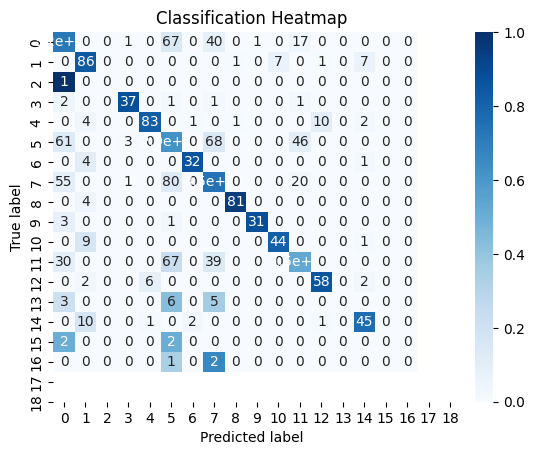

In [74]:
model = gather_data["svm_expanded"]["model"]

X_train = gather_data["svm_expanded"]["X_train"]
X_test = gather_data["svm_expanded"]["X_test"]

y_train = X_train_main.loc[:,"parallel"]
y_test = X_test_main.loc[:,"parallel"]

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

print("macro", f1_score(y_pred, y_test.values.ravel(),average='macro'))
print("micro", f1_score(y_pred, y_test.values.ravel(),average='micro'))

gather_results["svm_19_labels"] = {"micro f1":f1_score(y_pred,y_test,average='micro'), "macro":f1_score(y_pred,y_test,average='macro')}

gather_data["svm_19_labels"] = {"X_train":X_train,"y_train":y_train,"X_test":X_test,"y_test":y_test,"model":model, "y_pred":y_pred}


print(classification_report(y_pred.ravel(),y_test.values.ravel()))

heatmap(y_test, y_pred, 19)

In [75]:
print(len(ft))
sc = RobustScaler()
X = X_train_main.loc[:, ft].copy().copy()
X = sc.fit_transform(X)
X = pd.DataFrame(X, columns=ft)
X = X.loc[:, ft]
y = X_train_main.loc[:, "parallel"].copy().copy()

predictor = RandomForestClassifier(random_state=42)
backward_best_features = backward_elimination(X, y, predictor, f1_score)
print("Best features using backward elimination:", backward_best_features)

forward_best_features = forward_selection(X, y, predictor, f1_score)
print("Best features using forward selection:", forward_best_features)

11


100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [59:14<00:00, 323.17s/it]


Best features using backward elimination: ['no_trips', 'grt', 'diff']


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [02:13<00:00, 12.14s/it]

Best features using forward selection: ['no_trips', 'current_port', 'grt', 'teu', 'length', 'width', 'diff']


macro 0.5979208214124606
micro 0.6843633347158855
              precision    recall  f1-score   support

           0       0.59      0.68      0.63       472
           1       0.01      0.02      0.02       111
           2       0.00      0.00      0.00         0
           3       0.00      0.05      0.01        43
           4       0.00      0.00      0.00        89
           5       0.14      0.13      0.13       393
           6       0.03      0.04      0.03        45
           7       0.25      0.00      0.00       683
           8       0.00      0.00      0.00        83
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00        57
          11       0.00      0.00      0.00       281
          12       0.00      0.00      0.00        70
          14       0.00      0.00      0.00        51

    accuracy                           0.16      2411
   macro avg       0.07      0.07      0.06      2411
weighted avg       0.21      0

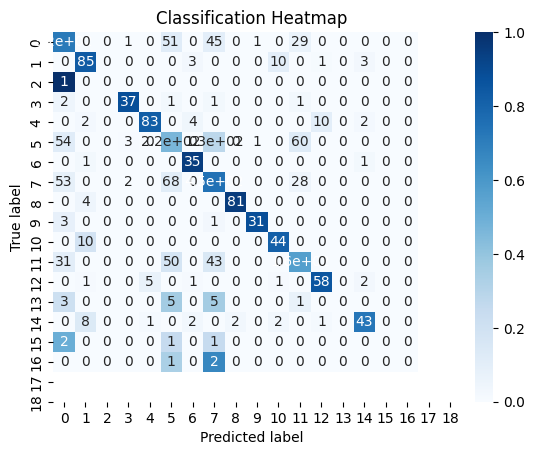

In [76]:
model = gather_data["lr_expanded"]["model"]

X_train = gather_data["lr_expanded"]["X_train"]
X_test = gather_data["lr_expanded"]["X_test"]

y_train = X_train_main.loc[:,"parallel"]
y_test = X_test_main.loc[:,"parallel"]

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

print("macro", f1_score(y_pred, y_test.values.ravel(),average='macro'))
print("micro", f1_score(y_pred, y_test.values.ravel(),average='micro'))

gather_results["lr_expanded_19_labels"] = {"micro f1":f1_score(y_pred,y_test,average='micro'), "macro":f1_score(y_pred,y_test,average='macro')}

print(classification_report(y_pred.ravel(),y_test_main.values.ravel()))


gather_data["lr_expanded_19_labels"] = {"X_train":X_train,"y_train":y_train,"X_test":X_test,"y_test":y_test,"model":model, "y_pred":y_pred}

heatmap(y_test, y_pred, 19)

macro 0.5515216259407129
micro 0.6731646619659892
              precision    recall  f1-score   support

           0       0.54      0.66      0.60       452
           1       0.01      0.02      0.02        96
           2       0.00      0.00      0.00         0
           3       0.00      0.06      0.01        47
           4       0.00      0.00      0.00        92
           5       0.21      0.13      0.16       575
           6       0.03      0.05      0.04        37
           7       0.25      0.00      0.00       616
           8       0.00      0.00      0.00        86
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00        59
          11       0.00      0.00      0.00       208
          12       0.00      0.00      0.00        77
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00        59
          15       0.00      0.00      0.00         1

    accuracy                  

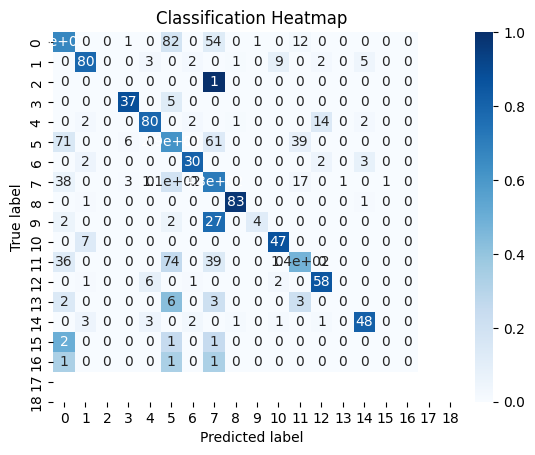

In [77]:
model = gather_data["rfr_poly_cluster_expanded"]["model"]

X_train = gather_data["rfr_poly_cluster_expanded"]["X_train"]
X_test = gather_data["rfr_poly_cluster_expanded"]["X_test"]

y_train = X_train_main.loc[:,"parallel"]
y_test = X_test_main.loc[:,"parallel"]

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

print("macro", f1_score(y_pred, y_test.values.ravel(),average='macro'))
print("micro", f1_score(y_pred, y_test.values.ravel(),average='micro'))

gather_results["rfr_poly_cluster_expanded_19_labels"] = {"micro f1":f1_score(y_pred,y_test,average='micro'), "macro":f1_score(y_pred,y_test,average='macro')}

print(classification_report(y_pred.ravel(),y_test_main.values.ravel()))

gather_data["rfr_poly_cluster_expanded_19_labels"] = {"X_train":X_train,"y_train":y_train,"X_test":X_test,"y_test":y_test,"model":model, "y_pred":y_pred}

heatmap(y_test, y_pred, 19)

##### best model so far

In [78]:
best_model = pd.DataFrame.from_dict(gather_results).T.sort_values(by="macro",ascending=False).index[0]

In [79]:
print(f"{best_model} is the best model so far")

svm_19_labels is the best model so far


In [80]:
model = gather_data[best_model]["model"]

X_train = gather_data[best_model]["X_train"].loc[:, backward_best_features+expanded_cols]
X_test = gather_data[best_model]["X_test"].loc[:, backward_best_features+expanded_cols]
y_train = gather_data[best_model]["y_train"]
y_test = gather_data[best_model]["y_test"]
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

print("micro", f1_score(y_pred, y_test.values.ravel(),average='micro'))
print("macro", f1_score(y_pred, y_test.values.ravel(),average='macro'))
print(classification_report(y_pred.ravel(),y_test_main.values.ravel()))

micro 0.7092492741600995
macro 0.6096462780949949
              precision    recall  f1-score   support

           0       0.58      0.67      0.62       476
           1       0.03      0.03      0.03       118
           2       0.00      0.00      0.00         0
           3       0.00      0.02      0.00        42
           4       0.00      0.00      0.00        90
           5       0.18      0.12      0.15       507
           6       0.03      0.06      0.04        35
           7       0.00      0.00      0.00       603
           8       0.00      0.00      0.00        83
           9       0.00      0.00      0.00        32
          10       0.00      0.00      0.00        51
          11       0.00      0.00      0.00       245
          12       0.00      0.00      0.00        70
          14       0.00      0.00      0.00        59

    accuracy                           0.16      2411
   macro avg       0.06      0.07      0.06      2411
weighted avg       0.15      0

In [81]:
tmp2.shape, gather_data[best_model]["X_test"].loc[:, forward_best_features+expanded_cols].shape

((2411, 3), (2411, 56))

best model with expanded cols (one hot vectors)

In [82]:
model = gather_data[best_model]["model"]

X_train = gather_data[best_model]["X_train"].loc[:, forward_best_features+expanded_cols]
X_train = pd.concat([X_train, tmp1],axis=1)
X_test = gather_data[best_model]["X_test"].loc[:, forward_best_features+expanded_cols]
X_test = pd.concat([X_test.reset_index(drop=True), tmp2.reset_index(drop=True)],axis=1)
y_train = gather_data[best_model]["y_train"]
y_test = gather_data[best_model]["y_test"]
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

print("micro", f1_score(y_pred, y_test.values.ravel(),average='micro'))
print("macro", f1_score(y_pred, y_test.values.ravel(),average='macro'))
print(classification_report(y_pred.ravel(),y_test.values.ravel()))

micro 0.7109083367897138
macro 0.6101265862596348
              precision    recall  f1-score   support

           0       0.71      0.68      0.69       475
           1       0.80      0.79      0.80       104
           2       0.00      0.00      0.00         0
           3       0.88      0.88      0.88        42
           4       0.81      0.92      0.86        89
           5       0.62      0.58      0.60       502
           6       0.86      0.86      0.86        37
           7       0.74      0.74      0.74       602
           8       0.95      0.99      0.97        82
           9       0.89      0.97      0.93        32
          10       0.81      0.86      0.84        51
          11       0.55      0.62      0.58       252
          12       0.85      0.83      0.84        70
          13       0.00      0.00      0.00         0
          14       0.86      0.70      0.77        73
          15       0.00      0.00      0.00         0
          17       0.00      0.

best model + clusters

In [83]:
model = gather_data[best_model]["model"]

X_train = gather_data[best_model]["X_train"].loc[:, backward_best_features+expanded_cols]
X_train = pd.concat([X_train, tmp1],axis=1)
X_test = gather_data[best_model]["X_test"].loc[:, backward_best_features+expanded_cols]
X_test = pd.concat([X_test.reset_index(drop=True), tmp2.reset_index(drop=True)],axis=1)
y_train = gather_data[best_model]["y_train"]
y_test = gather_data[best_model]["y_test"]
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

print("micro", f1_score(y_pred, y_test.values.ravel(),average='micro'))
print("macro", f1_score(y_pred, y_test.values.ravel(),average='macro'))
print(classification_report(y_pred.ravel(),y_test.values.ravel()))

micro 0.7096640398175031
macro 0.6106284712266918
              precision    recall  f1-score   support

           0       0.71      0.68      0.69       474
           1       0.80      0.80      0.80       103
           2       0.00      0.00      0.00         0
           3       0.88      0.88      0.88        42
           4       0.81      0.93      0.87        88
           5       0.62      0.57      0.60       503
           6       0.86      0.89      0.88        36
           7       0.74      0.74      0.74       603
           8       0.95      0.99      0.97        82
           9       0.89      0.97      0.93        32
          10       0.81      0.86      0.84        51
          11       0.55      0.62      0.58       251
          12       0.85      0.83      0.84        70
          13       0.00      0.00      0.00         0
          14       0.88      0.68      0.77        76
          15       0.00      0.00      0.00         0
          17       0.00      0.

In [84]:
to_compare = pd.DataFrame()
to_compare['id_on_port'] = pd.DataFrame(y_test)
to_compare["predictions"] = y_pred.tolist()
wrong_preds = to_compare.loc[to_compare["id_on_port"]!=to_compare["predictions"],:].index
to_compare["current_port"] = X_test_main.loc[X_test_main.index.isin(wrong_preds),["current_port"]]
to_compare["current_terminal"] = X_test_main.loc[X_test_main.index.isin(wrong_preds),["concat"]]

to_compare = to_compare.dropna()
print(f"{to_compare.shape[0]} were missclassified but it wasn't due to the final number of categories max(port_HAM,port_LA)")

700 were missclassified but it wasn't due to the final number of categories max(port_HAM,port_LA)


Hamburg is 0 LA is 1

In [85]:
to_compare.loc[to_compare["current_port"]==0,:]

,id_on_port,predictions,current_port,current_terminal
9646,0,5,0.0,0__HAMBURG
9648,7,0,0.0,3__HAMBURG
9650,9,0,0.0,4__HAMBURG
9652,0,7,0.0,0__HAMBURG
9653,11,5,0.0,5__HAMBURG
...,...,...,...,...
12033,0,5,0.0,0__HAMBURG
12039,5,11,0.0,2__HAMBURG
12046,5,11,0.0,2__HAMBURG
12052,0,5,0.0,0__HAMBURG


In [86]:
to_compare.loc[to_compare["current_port"]==0,"predictions"].unique()

array([ 5,  0,  7, 11,  3,  9], dtype=int64)

In [87]:
to_compare.loc[to_compare["current_port"]==1,:]

,id_on_port,predictions,current_port,current_terminal
9680,1,14,1.0,0__LOS ANGELES
9692,4,12,1.0,1__LOS ANGELES
9693,12,4,1.0,5__LOS ANGELES
9694,6,14,1.0,2__LOS ANGELES
9712,1,14,1.0,0__LOS ANGELES
...,...,...,...,...
11878,1,10,1.0,0__LOS ANGELES
11912,14,6,1.0,6__LOS ANGELES
11919,12,4,1.0,5__LOS ANGELES
12025,4,6,1.0,1__LOS ANGELES


In [88]:
to_compare.loc[(to_compare["current_port"]==0),:]

,id_on_port,predictions,current_port,current_terminal
9646,0,5,0.0,0__HAMBURG
9648,7,0,0.0,3__HAMBURG
9650,9,0,0.0,4__HAMBURG
9652,0,7,0.0,0__HAMBURG
9653,11,5,0.0,5__HAMBURG
...,...,...,...,...
12033,0,5,0.0,0__HAMBURG
12039,5,11,0.0,2__HAMBURG
12046,5,11,0.0,2__HAMBURG
12052,0,5,0.0,0__HAMBURG


In [89]:
mis_HA = to_compare.loc[to_compare["current_port"]==0,"predictions"].unique()

In [90]:
mis_LA = to_compare.loc[to_compare["current_port"]==1,"predictions"].unique()

In [91]:
Counter(to_compare.loc[to_compare["id_on_port"].isin(mis_LA),"current_terminal"].to_list())

Counter({'0__LOS ANGELES': 20,
         '1__LOS ANGELES': 19,
         '5__LOS ANGELES': 10,
         '2__LOS ANGELES': 5,
         '6__LOS ANGELES': 7,
         '4__LOS ANGELES': 10,
         '3__LOS ANGELES': 4})

In [92]:
Counter(to_compare.loc[to_compare["id_on_port"].isin(mis_HA),"current_terminal"].to_list())

Counter({'0__HAMBURG': 130,
         '3__HAMBURG': 156,
         '4__HAMBURG': 4,
         '5__HAMBURG': 130,
         '2__HAMBURG': 178,
         '1__HAMBURG': 5})

#### this is the distribution on the train.

In [93]:
Counter(X_train_main.loc[:,"concat"].to_list())

Counter({'0__HAMBURG': 2124,
         '1__HAMBURG': 224,
         '2__HAMBURG': 1846,
         '3__HAMBURG': 2236,
         '0__LOS ANGELES': 412,
         '4__HAMBURG': 122,
         '5__HAMBURG': 897,
         '1__LOS ANGELES': 384,
         '2__LOS ANGELES': 188,
         '3__LOS ANGELES': 384,
         '4__LOS ANGELES': 217,
         '5__LOS ANGELES': 287,
         '6__LOS ANGELES': 264,
         '6__HAMBURG': 26,
         '7__HAMBURG': 24,
         '8__HAMBURG': 6,
         '9__HAMBURG': 1,
         '7__LOS ANGELES': 1})

Something that completely makes sense since the examples for the terminal 7 and above for each port have extremely low occurence.

Essentially that plays a role on the misbehaviors of the best performing model so far.

# Conclusions

1 & 2. The features finally selected are coming from the backwards and the forward eliminations. 
Correlation of the features did give an insight along with logistic regression coefficients and random forests' feature importances, but essentially *correlation does not imply causation* so the safest way to decide was FE and BE.

3. My findings agree with the product team since there was a better result by using the actual historical data of each ship to predict the next destination. Before build the model you must check the relationship between the variables as well as their relationship with their target (independent variable).

4. It is evident that this is a pure classification problem since we're called to predict essentially a categorical variable.

5. Overall my model has a better accuracy than the baseline (thus proving there was room for improvement) but it had worse results from the baseline on getting better results *across all of the terminals*

6. The reasons that the algorithm has failed in several occasions is that there were categories with extremely low pupulation i.e. some terminals had up to 10 occurences of data whereas the biggest occurences were found on terminals with over 2000 visits.
Also i had 1 model for both LA and HAMBURG so there were bound to be some missclassifications i.e. over the 9nth terminal in LA. Especially since there were significantly less examples in the LA port. Of course post processing here
helps the results. One other way that i could have tackled this issue is to actually have 2 models but i believe the one model actually found correlations between some of the terminals for each port.

7. The most naive approach i could find here is to actually use the previous visit on the current port as the prediction. Something which proved to be an excellent baseline.

## Possible future work

1. We could try ship embeddings.
2. Find a way to see if there is a cap on the occupation of each terminal so we can significantly reduce the search space of our predictions in production.
3. Even though i used the "diff" feature in the training, it would also be important to get the actual km distance from beggining to the end port.
4. We could try binning the "volume" of the ships that comes from a histogram as an extra feature.
5. Use extensive tuning on non linear ml algorithms but not DNNs since the dataset is quite small.
6. Post process by either performing clustering on the terminals (i.e. in case of invalid classification correct it with the closest valid terminal in the same cluster)

A bonus point for discussion:

Given the accuracy of your model, what would be the next steps in terms of deploying a solution such
that the model’s value to the business is maximised?


The first steps i would consider to maximize the business eficiency are:

1. Identify how to integrate the model into our workflow and actually set a shadow deployment for it.
2. Make sure that we use the proper tools for scaling it for larger datasets (and requests).
3. Evaluate the model in the inference by setting up an evaluation platform (this cannot be done manually for a long time).
4. Get feedback from the product on any tweaks that it might need to satisfy our customers.
5. Set up a plan to make sure it is futureproof and maintainable.
